In [2]:
from datetime import datetime, timedelta
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (15, 8)

**Data source - Worldmeters.info (as of Apr-8)**

Link: https://www.worldometers.info/coronavirus/country/us/

In [3]:
start = "Feb 15"
data = [0,0,0,0,0,20,0,0,18,4,3,0,3,5,7,25,24,34,63,98,116,106,163,290,307,329,553,587,843,983,1748,2949,4569,5632,4825,9400,10311,11166,13451,17388,18743,19452,19913,20732,24914,26619,30107,32398,34196,25316,31107,33460,31935]


In [4]:
# Preprocessing
start_date = datetime.strptime(start, '%b %d')
data = np.nan_to_num(np.array(data).astype(float))
x_val = list(range(len(data)))

In [5]:
# Fit normal distribution by minimizing sum-of-square-error
def fitness(param):
    mean, std, height = param
    y = norm.pdf(x_val, mean, std) * height
    return np.square(data - y[:len(data)]).sum() # SSE

param0 = [x_val[-1], len(data), max(data)]
res = minimize(fitness, param0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

mean, std, height = res.x
np.array([mean, std, height]).round(3)

Optimization terminated successfully.
         Current function value: 89594853.534484
         Iterations: 224
         Function evaluations: 438


array([5.01050000e+01, 9.08600000e+00, 7.25995053e+05])

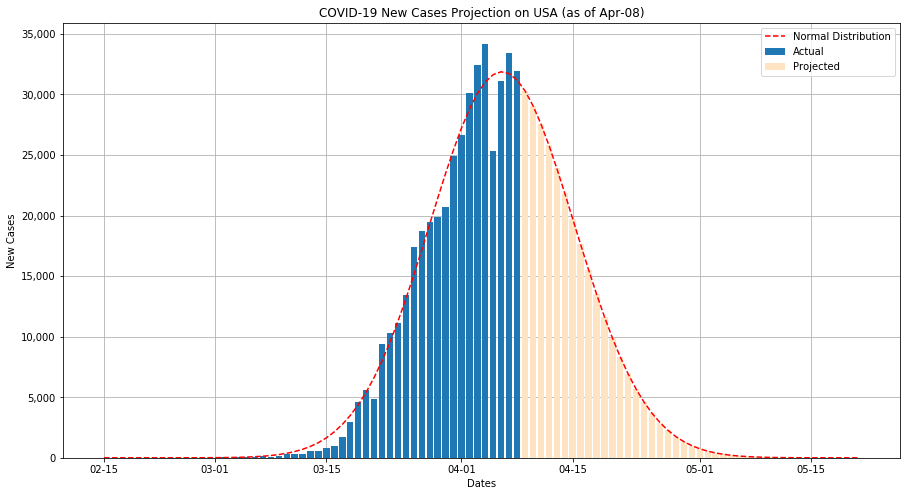

Current Actual: 434,912
Total with Projected: 722,410
99% Cases Before: Apr-30


In [6]:
# X-axis and Dates
x_full = list(range(data.argmax()*2))
d_full = [start_date + timedelta(days=x) for x in x_full]
as_of_date = datetime.strftime(d_full[len(data)-1], '%b-%d')

# Forecast based on fit
y_line = norm.pdf(x_full, mean, std) * height
y_bar = y_line.copy()
y_bar[:len(data)] = 0

# Find 99th percentile
s = y_line.sum() * 0.99
i = 0
c = 0
while c < s:
    c += y_line[i] if i >= len(data) else data[i]
    i += 1
d_percentile = d_full[i]

# Plot
fig, ax = plt.subplots()

ax.bar(d_full[:len(data)], data, label='Actual')
ax.bar(d_full, y_bar, color='bisque', label='Projected')
ax.plot(d_full, y_line, 'r--', label='Normal Distribution')

plt.title('COVID-19 New Cases Projection on USA (as of {})'.format(as_of_date))
plt.xlabel('Dates')
plt.ylabel('New Cases')
plt.legend()

y_formater = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.yaxis.set_major_formatter(y_formater)
x_formatter = matplotlib.dates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(x_formatter)
ax.set_axisbelow(True)
ax.xaxis.grid()
ax.yaxis.grid()

plt.show()

print('Current Actual: {:,.0f}'.format(sum(data)))
print('Total with Projected: {:,.0f}'.format(sum(data) + sum(y_line[len(data):])))
print('99% Cases Before: {}'.format(datetime.strftime(d_full[i], '%b-%d')))

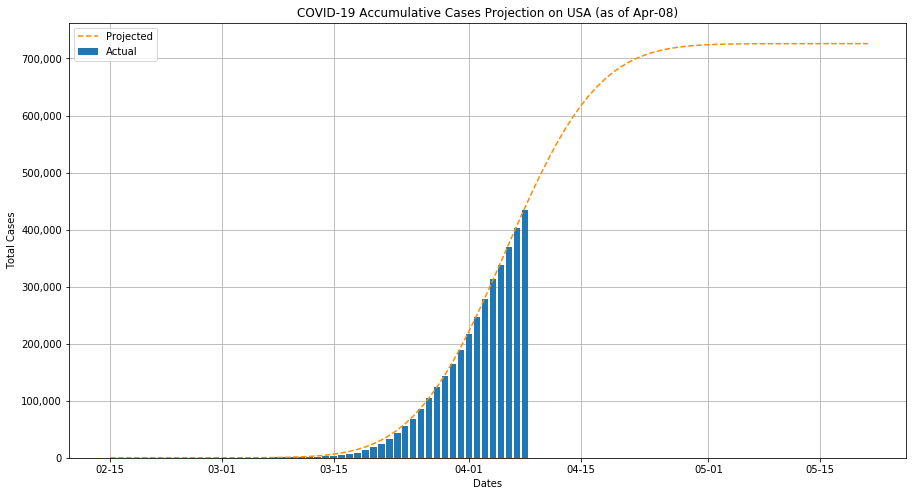

In [7]:
# Plot
fig, ax = plt.subplots()

ax.bar(d_full[:len(data)], data.cumsum(), label='Actual')
ax.plot(d_full, y_line.cumsum(), '--', label='Projected', color='darkorange')

plt.title('COVID-19 Accumulative Cases Projection on USA (as of {})'.format(as_of_date))
plt.xlabel('Dates')
plt.ylabel('Total Cases')
plt.legend()

y_formater = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.yaxis.set_major_formatter(y_formater)
x_formatter = matplotlib.dates.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(x_formatter)
ax.set_axisbelow(True)
ax.xaxis.grid()
ax.yaxis.grid()

plt.show()